##Fit betas match-non-match data
July.2015 high-resolution CMRR data for the "match_nonmatch" project.

Project notes: https://drive.google.com/open?id=1m1rmotkmtgwY99Q_k71YDorUPq_DkCSJ0LselY13_v4

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import hrf_fitting.src.preprocessing as preproc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import nibabel as nib
import pickle
import matplotlib.animation as animation
import hrf_estimation as he
import operator

from PIL import Image
from hrf_fitting.src.features import construct_placement_grid,make_kernel_grid,complex_ripple_filter,compute_grid_corners
from scipy.signal import convolve2d
from os import path
from sklearn import linear_model
from glob import glob
from sklearn.metrics import explained_variance_score,r2_score
from scipy.stats.mstats import zscore
from joblib import Parallel, delayed
from time import time
from scipy.interpolate import griddata

Populating the interactive namespace from numpy and matplotlib


###Select data

select a subject and corresponding database

In [2]:
subject = 's1055'
db =  '/media/tnaselar/Data/July_2015_preproc/'+subject+'/PS/aligned_db.csv'

import into pandas dataframe and view it

In [3]:
data_db = pd.io.parsers.read_csv(db,header=0)
data_db

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
0,0,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
1,1,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
2,2,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
3,3,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
4,4,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
5,5,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,img,none,run_0.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T./musc.repo/mri/7T.cmrr/July....,0,0
6,6,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,img,none,run_1.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T./musc.repo/mri/7T.cmrr/July....,0,0
7,7,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,img,none,run_2.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T./musc.repo/mri/7T.cmrr/July....,0,0
8,8,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,img,none,run_3.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T./musc.repo/mri/7T.cmrr/July....,0,0
9,9,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,img,none,run_6.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T./musc.repo/mri/7T.cmrr/July....,0,0


###Specify runs for training and testing the model

In [4]:
def select_run(row,runType):
    return row['runType'] in [runType]


img_runs = list(data_db[data_db.apply(select_run,axis=1,args=('img',))].runID)  ##<<this is the match/non-match



In [5]:
data_db.iloc[img_runs]

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
5,5,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,img,none,run_0.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T./musc.repo/mri/7T.cmrr/July....,0,0
6,6,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,img,none,run_1.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T./musc.repo/mri/7T.cmrr/July....,0,0
7,7,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,img,none,run_2.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T./musc.repo/mri/7T.cmrr/July....,0,0
8,8,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,img,none,run_3.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T./musc.repo/mri/7T.cmrr/July....,0,0
9,9,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,img,none,run_6.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T./musc.repo/mri/7T.cmrr/July....,0,0
10,10,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,img,none,run_7.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T./musc.repo/mri/7T.cmrr/July....,0,0
11,11,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,img,none,run_4.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T./musc.repo/mri/7T.cmrr/July....,0,0
12,12,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,img,none,run_5.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T./musc.repo/mri/7T.cmrr/July....,0,0


###Load neural data

In [6]:
try:
    img_vols = preproc.load_runs(data_db,img_runs)
except: ##probably only one run
    img_runs = [img_runs]
    img_vols = preproc.load_runs(data_db,img_runs)

detrending run 0 with window_length: 105
detrending run 1 with window_length: 103
detrending run 2 with window_length: 105
detrending run 3 with window_length: 107
detrending run 4 with window_length: 105
detrending run 5 with window_length: 105
detrending run 6 with window_length: 105
detrending run 7 with window_length: 105
zscoring 0 thru 209
zscoring 209 thru 416
zscoring 416 thru 626
zscoring 626 thru 838
zscoring 838 thru 1049
zscoring 1049 thru 1258
zscoring 1258 thru 1466
zscoring 1466 thru 1674


Reshape, mask, and remove inf's. Need to add this functionality to "load_runs"

In [7]:
##optional coronal slice selection
first_slice,last_slice = -25,-1

##first the mask. mucked up the database somehow, so reading in the brain mask is a stupid mess
bm = glob('/media'+data_db.iloc[img_runs[0]]['brain_mask'].split('/media')[2]+'/*.gz')
mask_image = nib.load(bm[0]).get_data().astype('bool') ##a numpy boolean

##now some indices for coronal slicing.
zdx = np.zeros(img_vols.shape[0:3]).astype('bool')
zdx[:,:,first_slice:last_slice] = True

##can't use any of the voxels with knackered values
finite_voxels = np.isfinite(img_vols.get_data()).all(axis=3)*np.isfinite(img_vols.get_data()).all(axis=3)

mask_image = mask_image*zdx*finite_voxels

In [8]:
def apply_mask(vol,raveled_mask):
    vol = vol.get_data().reshape((np.prod(vol.shape[0:3]),vol.shape[3])).T  ##converts to (time, xyz)
    return vol[:,raveled_mask]
    

In [9]:
##test masking
mean_vol = preproc.load_runs(data_db,img_runs[0:2],detrend=False,z_score=False)
mean_vol = apply_mask(mean_vol,mask_image.ravel()).mean(axis=0)
test_view = np.zeros(mask_image.shape).ravel()
test_view[mask_image.ravel()] = mean_vol
test_view = test_view.reshape(mask_image.shape)

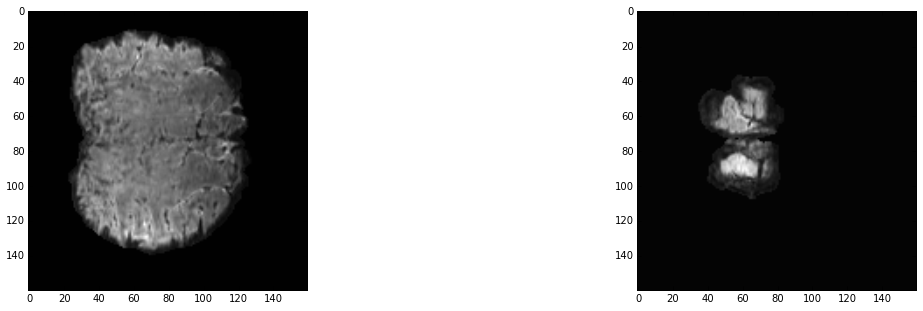

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(test_view[:,:,first_slice],cmap=cm.gray)
plt.subplot(1,2,2)
plt.imshow(test_view[:,:,last_slice-1],cmap=cm.gray)

In [11]:
img_vols = apply_mask(img_vols,mask_image.ravel())

In [12]:
print 'img_vols dimensions: %s' %(img_vols.shape,)

img_vols dimensions: (1674, 165406)


###Construct conditions matrices
Note that chunkwise_downsampling not needed here because the chunksize is 1.

In [13]:
frame_lists = []
for _,row in data_db.iloc[img_runs].iterrows():
    frame_lists.append(preproc.load_frame_file(row))

In [14]:
##check
frame_lists[0][0:20]

['isi_screen.png',
 'isi_screen.png',
 'isi_screen.png',
 'isi_screen.png',
 'southwest_003412_base.png',
 'imagery_screen.png',
 'southwest_003412_patch.png',
 'isi_screen.png',
 'southeast_003277_base.png',
 'imagery_screen.png',
 'southeast_003277_patch.png',
 'isi_screen.png',
 'isi_screen.png',
 'northwest_003167_base.png',
 'imagery_screen.png',
 'northwest_003167_patch.png',
 'isi_screen.png',
 'isi_screen.png',
 'southwest_003770_base.png',
 'imagery_screen.png']

The "imagery_screen" frame needs to be associated with a specific base/patch set. Do that processing here.

In [15]:
for run in frame_lists:
    for ii,frame in enumerate(run):
        if 'base' in frame:
            base = frame[:-8]
        if "imagery_screen" in frame:
            run[ii]=base+frame
    

The "patch" frames need to be labeled as "match" or "non-match". Do that processing here.


In [16]:
for run in frame_lists:
    for ii,frame in enumerate(run):
        if 'base' in frame:
            base = frame[:-8]
        if 'patch' in frame:
            if frame[:-9] == base:
                run[ii]='match_'+frame
            else:
                run[ii]='non_match_'+frame

In [17]:
frame_lists[0]

['isi_screen.png',
 'isi_screen.png',
 'isi_screen.png',
 'isi_screen.png',
 'southwest_003412_base.png',
 'southwest_003412_imagery_screen.png',
 'match_southwest_003412_patch.png',
 'isi_screen.png',
 'southeast_003277_base.png',
 'southeast_003277_imagery_screen.png',
 'match_southeast_003277_patch.png',
 'isi_screen.png',
 'isi_screen.png',
 'northwest_003167_base.png',
 'northwest_003167_imagery_screen.png',
 'match_northwest_003167_patch.png',
 'isi_screen.png',
 'isi_screen.png',
 'southwest_003770_base.png',
 'southwest_003770_imagery_screen.png',
 'non_match_southwest_003412_patch.png',
 'isi_screen.png',
 'northeast_004045_base.png',
 'northeast_004045_imagery_screen.png',
 'non_match_northeast_003860_patch.png',
 'isi_screen.png',
 'isi_screen.png',
 'southeast_003277_base.png',
 'southeast_003277_imagery_screen.png',
 'match_southeast_003277_patch.png',
 'isi_screen.png',
 'northeast_003860_base.png',
 'northeast_003860_imagery_screen.png',
 'match_northeast_003860_patch.pn

In [18]:
condition_map, condition_sequence, condition_onsets,conditions_matrix = preproc.construct_conditions_matrix([it for fl in frame_lists for it in fl],1.5,10,not_a_condition =['isi_screen.png'])

In [19]:
print len(condition_sequence)
print len(condition_onsets)

1152
1152


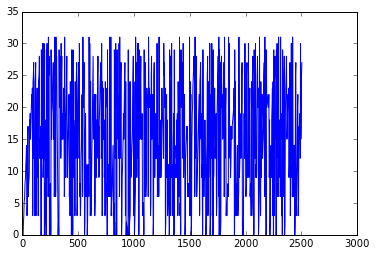

In [20]:
plt.plot(condition_onsets,condition_sequence)

In [21]:
sorted_cm = sorted(condition_map.items(), key=operator.itemgetter(1))
# condition_map
sorted_cm

[('southwest_003412_base.png', 0),
 ('southwest_003412_imagery_screen.png', 1),
 ('match_southwest_003412_patch.png', 2),
 ('southeast_003277_base.png', 3),
 ('southeast_003277_imagery_screen.png', 4),
 ('match_southeast_003277_patch.png', 5),
 ('northwest_003167_base.png', 6),
 ('northwest_003167_imagery_screen.png', 7),
 ('match_northwest_003167_patch.png', 8),
 ('southwest_003770_base.png', 9),
 ('southwest_003770_imagery_screen.png', 10),
 ('non_match_southwest_003412_patch.png', 11),
 ('northeast_004045_base.png', 12),
 ('northeast_004045_imagery_screen.png', 13),
 ('non_match_northeast_003860_patch.png', 14),
 ('northeast_003860_base.png', 15),
 ('northeast_003860_imagery_screen.png', 16),
 ('match_northeast_003860_patch.png', 17),
 ('match_southwest_003770_patch.png', 18),
 ('non_match_northeast_004045_patch.png', 19),
 ('northwest_004001_base.png', 20),
 ('northwest_004001_imagery_screen.png', 21),
 ('non_match_northwest_003167_patch.png', 22),
 ('match_northwest_004001_patch.p

(1674, 320)


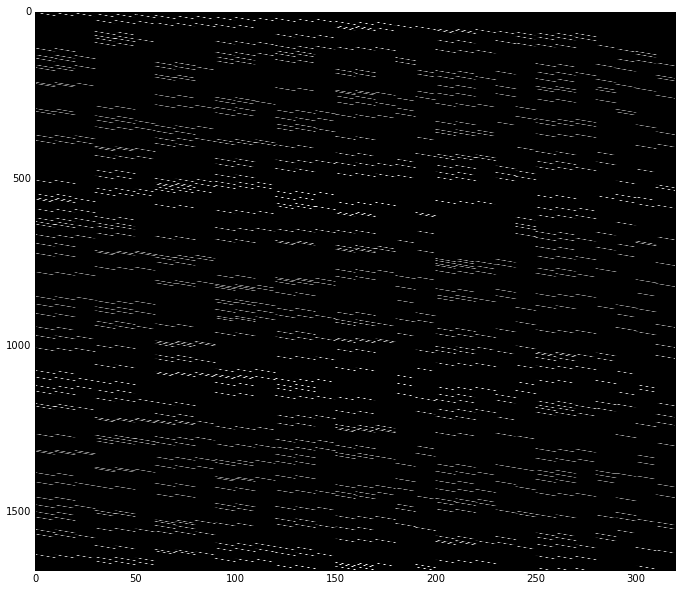

In [22]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)
ax.imshow(conditions_matrix, cmap=cm.gray)
ax.set_aspect(1/6.)
print conditions_matrix.shape

In [38]:
# we construct the matrix of drifts as the matrix of ones that account for
# the intercept term. If you have drifts estimated by e.g. SPM you can add
# them here.
drifts = np.ones((img_vols.shape[0], 1))

##fit this! 
hrfs, betas, dmtx = he.glm(condition_sequence, condition_onsets, 1.5, img_vols, drifts=drifts, mode='r1glm', basis='3hrf', verbose=1, return_design_matrix=True, n_jobs=4)

.. creating design matrix ..
.. done creating design matrix ..
.. computing initialization ..
.. done initialization ..
.. completed 500 out of 41351 ..
.. completed 500 out of 41352 ..
.. completed 500 out of 41351 ..
.. completed 500 out of 41352 ..
.. completed 1000 out of 41351 .... completed 1000 out of 41352 .... completed 1000 out of 41351 .... completed 1000 out of 41352 ..



.. completed 1500 out of 41351 .... completed 1500 out of 41352 .... completed 1500 out of 41351 .... completed 1500 out of 41352 ..



.. completed 2000 out of 41351 .... completed 2000 out of 41352 .... completed 2000 out of 41351 .... completed 2000 out of 41352 ..



.. completed 2500 out of 41351 .... completed 2500 out of 41352 .... completed 2500 out of 41351 .... completed 2500 out of 41352 ..



.. completed 3000 out of 41351 .... completed 3000 out of 41352 .... completed 3000 out of 41351 .... completed 3000 out of 41352 ..



.. completed 3500 out of 41351 .... completed 3500 out of 41352 ....

In [40]:
print betas.shape
print hrfs.shape
print dmtx.shape

(32, 165406)
(3, 165406)
(1674, 96)


(1674, 96)


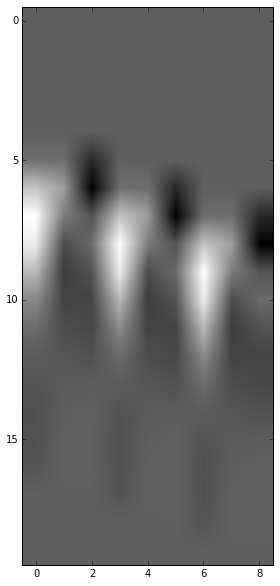

In [47]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)
ax.imshow(dmtx[0:20,0:9], cmap=cm.gray)
# ax.set_aspect(1/18.)
print dmtx.shape

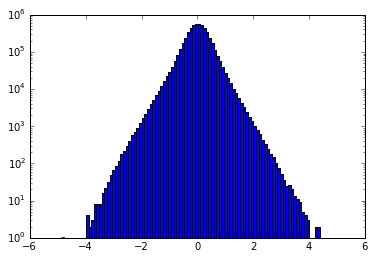

In [25]:
_=plt.hist(betas.ravel(),100,log=True)

In [26]:
xx = np.linspace(0, 25) # range of values for time
# construct the final HRF by multiplying by its basis
generated_hrfs = hrfs[0] * he.hrf.spmt(xx)[:, None] + hrfs[1] * he.hrf.dspmt(xx)[:, None] + hrfs[2] * he.hrf.ddspmt(xx)[:, None]

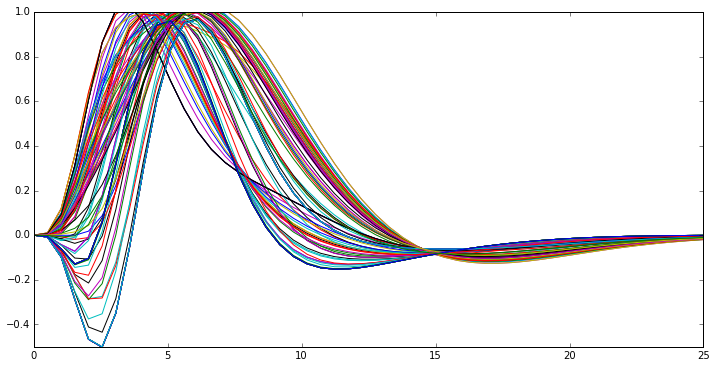

In [27]:
random_voxels = np.random.randint(0,high=hrfs.shape[1],size=100)
plt.figure(figsize=(12, 6))
plt.plot(xx, generated_hrfs[:,random_voxels])
plt.ylim((-.5, 1.))
plt.show()

In [28]:
brain_view = np.zeros(mask_image.shape).ravel()
brain_view[mask_image.ravel()] = mean_vol
brain_view = brain_view.reshape(mask_image.shape)


In [29]:
brain_view.shape 

(160, 160, 66)

In [30]:
beta_view = np.zeros((mask_image.ravel().shape)+(betas.shape[0],))
print beta_view.shape

(1689600, 32)


In [31]:
for b in range(betas.shape[0]):
    beta_view[mask_image.ravel(),b] = betas[b,:].T

In [32]:
beta_view = beta_view.reshape(mask_image.shape+(betas.shape[0],))
print beta_view.shape

(160, 160, 66, 32)


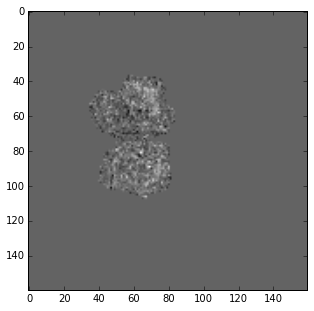

In [33]:
##sanity check
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plt.imshow(beta_view[:,:,64,1],cmap=cm.gray)
ax.set_aspect('equal')


In [34]:
nib.save(nib.Nifti1Image(brain_view,affine=np.eye(4)),'/media/tnaselar/Data/scratch/mnm_brain_beta_view.nii')

In [35]:
nib.save(nib.Nifti1Image(beta_view,affine=np.eye(4)),'/media/tnaselar/Data/scratch/mnm_beta_view.nii')

In [36]:
condition_map

{'match_northeast_003860_patch.png': 17,
 'match_northeast_004045_patch.png': 30,
 'match_northwest_003167_patch.png': 8,
 'match_northwest_004001_patch.png': 23,
 'match_southeast_003067_patch.png': 28,
 'match_southeast_003277_patch.png': 5,
 'match_southwest_003412_patch.png': 2,
 'match_southwest_003770_patch.png': 18,
 'non_match_northeast_003860_patch.png': 14,
 'non_match_northeast_004045_patch.png': 19,
 'non_match_northwest_003167_patch.png': 22,
 'non_match_northwest_004001_patch.png': 31,
 'non_match_southeast_003067_patch.png': 24,
 'non_match_southeast_003277_patch.png': 27,
 'non_match_southwest_003412_patch.png': 11,
 'non_match_southwest_003770_patch.png': 29,
 'northeast_003860_base.png': 15,
 'northeast_003860_imagery_screen.png': 16,
 'northeast_004045_base.png': 12,
 'northeast_004045_imagery_screen.png': 13,
 'northwest_003167_base.png': 6,
 'northwest_003167_imagery_screen.png': 7,
 'northwest_004001_base.png': 20,
 'northwest_004001_imagery_screen.png': 21,
 'sou

In [37]:
condition_sequence

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 3,
 4,
 5,
 15,
 16,
 17,
 6,
 7,
 8,
 9,
 10,
 18,
 15,
 16,
 19,
 15,
 16,
 17,
 20,
 21,
 22,
 20,
 21,
 23,
 3,
 4,
 24,
 25,
 26,
 27,
 12,
 13,
 14,
 3,
 4,
 24,
 25,
 26,
 27,
 3,
 4,
 5,
 20,
 21,
 23,
 9,
 10,
 11,
 3,
 4,
 24,
 25,
 26,
 28,
 12,
 13,
 14,
 15,
 16,
 17,
 0,
 1,
 29,
 20,
 21,
 22,
 12,
 13,
 30,
 9,
 10,
 11,
 12,
 13,
 30,
 0,
 1,
 2,
 9,
 10,
 18,
 0,
 1,
 29,
 12,
 13,
 30,
 9,
 10,
 18,
 6,
 7,
 31,
 25,
 26,
 28,
 0,
 1,
 2,
 6,
 7,
 8,
 0,
 1,
 29,
 15,
 16,
 19,
 20,
 21,
 23,
 25,
 26,
 27,
 15,
 16,
 19,
 6,
 7,
 31,
 20,
 21,
 22,
 6,
 7,
 31,
 25,
 26,
 28,
 0,
 1,
 2,
 0,
 1,
 29,
 20,
 21,
 23,
 25,
 26,
 28,
 12,
 13,
 30,
 25,
 26,
 28,
 15,
 16,
 19,
 15,
 16,
 17,
 20,
 21,
 23,
 6,
 7,
 31,
 15,
 16,
 19,
 9,
 10,
 18,
 25,
 26,
 28,
 9,
 10,
 11,
 15,
 16,
 17,
 20,
 21,
 22,
 6,
 7,
 8,
 3,
 4,
 24,
 9,
 10,
 18,
 0,
 1,
 29,
 12,
 13,
 14,
 0,
 1,
 29,
 9,
 10,
 18,
 15,
 